In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import env
import wrangle

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Acquare Zillow data from SQL

In [2]:
# SQL query

sql = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 

FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
"""

In [3]:
def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

In [4]:
# acquire zillow data using the query
def get_zillow(sql):
    url = get_db_url('zillow')
    zillow_df = pd.read_sql(sql, url)
    return zillow_df

In [5]:
# get data from SQl and save as csv locally

df = get_zillow(sql)
df.to_csv("zillow.csv")

In [6]:
# read the previously saved csv file

df = pd.read_csv("zillow.csv")

### Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)¶


In [7]:
df.head()

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [8]:
df.shape

(77574, 69)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    77574 non-null  int64  
 1   id                            77574 non-null  int64  
 2   parcelid                      77574 non-null  int64  
 3   airconditioningtypeid         25006 non-null  float64
 4   architecturalstyletypeid      206 non-null    float64
 5   basementsqft                  50 non-null     float64
 6   bathroomcnt                   77574 non-null  float64
 7   bedroomcnt                    77574 non-null  float64
 8   buildingclasstypeid           15 non-null     float64
 9   buildingqualitytypeid         49808 non-null  float64
 10  calculatedbathnbr             76959 non-null  float64
 11  decktypeid                    614 non-null    float64
 12  finishedfloor1squarefeet      6035 non-null   float64
 13  c

In [10]:
# look at nulls in each columns

df.isnull().sum().sort_values(ascending = False)[:45]

buildingclasstypeid         77559
buildingclassdesc           77559
finishedsquarefeet13        77532
storytypeid                 77524
storydesc                   77524
basementsqft                77524
yardbuildingsqft26          77504
fireplaceflag               77402
architecturalstyletypeid    77368
architecturalstyledesc      77368
typeconstructiondesc        77352
typeconstructiontypeid      77352
finishedsquarefeet6         77188
pooltypeid10                77109
decktypeid                  76960
poolsizesum                 76705
pooltypeid2                 76500
hashottuborspa              76035
yardbuildingsqft17          75181
taxdelinquencyflag          74674
taxdelinquencyyear          74674
finishedsquarefeet15        74547
finishedsquarefeet50        71539
finishedfloor1squarefeet    71539
fireplacecnt                69287
threequarterbathnbr         67469
pooltypeid7                 62496
poolcnt                     61401
numberofstories             59978
airconditionin

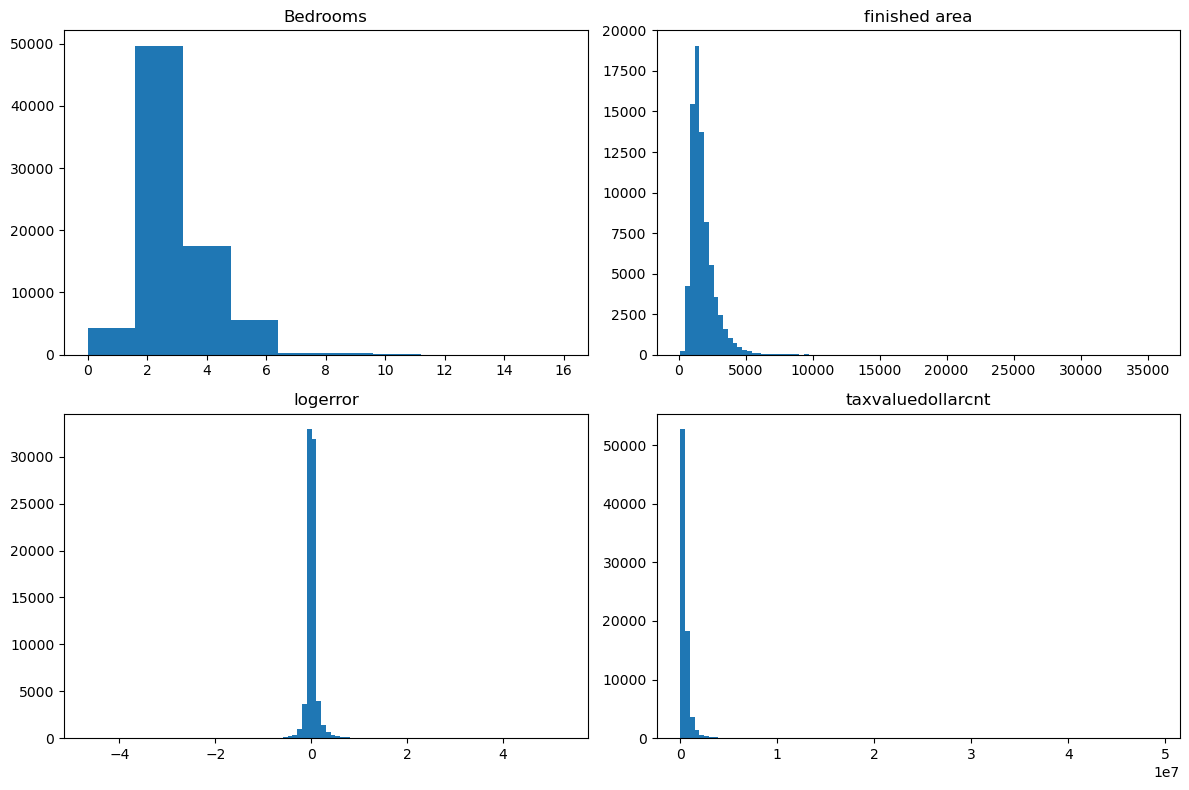

In [11]:
# plot some distributions 

plt.figure(figsize = (12,8))
plt.subplot(221)
plt.hist(df.bedroomcnt, bins = 10)
plt.title('Bedrooms')



plt.subplot(222)
plt.hist(df.calculatedfinishedsquarefeet, bins = 100)
plt.title('finished area')



plt.subplot(223)
plt.hist(df.logerror, bins = 100)
plt.title('logerror')



plt.subplot(224)
plt.hist(df.taxvaluedollarcnt, bins = 100)
plt.title('taxvaluedollarcnt')

plt.tight_layout();

#### Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [12]:
df.isnull().sum()

Unnamed: 0                      0
id                              0
parcelid                        0
airconditioningtypeid       52568
architecturalstyletypeid    77368
                            ...  
buildingclassdesc           77559
heatingorsystemdesc         28005
propertylandusedesc             0
storydesc                   77524
typeconstructiondesc        77352
Length: 69, dtype: int64

In [13]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing / rows
    cols_missing = pd.DataFrame({'number_missing_rows': num_missing, 'percent_rows_missing': pct_missing})
    return cols_missing

In [14]:
nulls_by_column = nulls_by_col(df)
nulls_by_column.sort_values(by="percent_rows_missing", ascending=False).head(40)

,number_missing_rows,percent_rows_missing
buildingclasstypeid,77559,0.999807
buildingclassdesc,77559,0.999807
finishedsquarefeet13,77532,0.999459
storytypeid,77524,0.999355
storydesc,77524,0.999355
basementsqft,77524,0.999355
yardbuildingsqft26,77504,0.999098
fireplaceflag,77402,0.997783
architecturalstyletypeid,77368,0.997344
architecturalstyledesc,77368,0.997344


#### Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [15]:
#check data shape
df.shape

(77574, 69)

In [16]:
# look at value counts for 'unitcnt'

df.unitcnt.value_counts(dropna = False)

1.0      47412
NaN      26872
2.0       2031
4.0        726
3.0        529
45.0         1
42.0         1
6.0          1
237.0        1
Name: unitcnt, dtype: int64

In [17]:
# Restrict df to only properties that meet single unit criteria

single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
df = df[df.propertylandusetypeid.isin(single_use)]
    
    
# Restrict df to only those properties with at least 1 bath & bed and >350 sqft area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull()) & (df.calculatedfinishedsquarefeet>350)]


In [18]:
# check # of columns and rows left
df.shape

(71355, 69)

#### Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

In [19]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .70):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [20]:
# use the function defined above:

df = handle_missing_values(df)

In [21]:
# check shape to see how many columns and rows were dropped

df.shape

(71355, 35)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71355 entries, 0 to 77573
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    71355 non-null  int64  
 1   id                            71355 non-null  int64  
 2   parcelid                      71355 non-null  int64  
 3   bathroomcnt                   71355 non-null  float64
 4   bedroomcnt                    71355 non-null  float64
 5   buildingqualitytypeid         44841 non-null  float64
 6   calculatedbathnbr             71340 non-null  float64
 7   calculatedfinishedsquarefeet  71355 non-null  float64
 8   finishedsquarefeet12          71188 non-null  float64
 9   fips                          71355 non-null  float64
 10  fullbathcnt                   71340 non-null  float64
 11  heatingorsystemtypeid         46412 non-null  float64
 12  latitude                      71355 non-null  float64
 13  l

In [23]:
# look at number of nulls for each column
df.isnull().sum()

Unnamed: 0                          0
id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           26514
calculatedbathnbr                  15
calculatedfinishedsquarefeet        0
finishedsquarefeet12              167
fips                                0
fullbathcnt                        15
heatingorsystemtypeid           24943
latitude                            0
longitude                           0
lotsizesquarefeet                8034
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              26221
rawcensustractandblock              0
regionidcity                     1322
regionidcounty                      0
regionidzip                        40
roomcnt                             0
unitcnt                         26195
yearbuilt                          35
structuretaxvaluedollarcnt         75
taxvaluedoll

In [24]:
# use your judgement to remove certain columns which you don't need

cols_to_remove = ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc', 'unitcnt']

In [25]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [26]:
# use the function defined above to remove the columns not needed:

df = remove_columns(df, cols_to_remove)

In [27]:
# take a look at null counts again

df.isnull().sum()

Unnamed: 0                          0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           26514
calculatedfinishedsquarefeet        0
fips                                0
latitude                            0
longitude                           0
lotsizesquarefeet                8034
rawcensustractandblock              0
regionidcity                     1322
regionidcounty                      0
regionidzip                        40
roomcnt                             0
yearbuilt                          35
structuretaxvaluedollarcnt         75
taxvaluedollarcnt                   1
assessmentyear                      0
landtaxvaluedollarcnt               1
taxamount                           5
logerror                            0
transactiondate                     0
heatingorsystemdesc             24943
dtype: int64

In [28]:
# let's look at heatingorsystemdesc value counts

df.heatingorsystemdesc.value_counts(dropna = False)

Central       31357
NaN           24943
Floor/Wall    13229
Yes             850
Forced air      775
Solar           101
None             60
Radiant          23
Baseboard        13
Gravity           3
Heat Pump         1
Name: heatingorsystemdesc, dtype: int64

In [29]:
df.fips.value_counts()

6037.0    45320
6059.0    20289
6111.0     5746
Name: fips, dtype: int64

In [30]:
# how many missing values by county?
df[df.fips == 6111].heatingorsystemdesc.value_counts(dropna = False)

NaN    5746
Name: heatingorsystemdesc, dtype: int64

In [31]:
# We don't want to remove an entire value from fips, so we will drop this column entirely 

df.drop(columns = 'heatingorsystemdesc', inplace = True)

In [32]:
# buildingqualitytypeid
# Overall assessment of condition of the building from 
# low number = best quality
# higher numbers = worse quality

df.buildingqualitytypeid.value_counts(dropna = False)

NaN     26514
8.0     13404
6.0     12673
4.0      8226
7.0      5505
9.0      2113
5.0      1499
11.0      846
10.0      301
3.0       149
12.0      113
1.0         9
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [33]:
df[df.fips == 6059].buildingqualitytypeid.value_counts(dropna = False)

NaN    20289
Name: buildingqualitytypeid, dtype: int64

In [34]:
# Check work
df.buildingqualitytypeid.value_counts(dropna = False)

NaN     26514
8.0     13404
6.0     12673
4.0      8226
7.0      5505
9.0      2113
5.0      1499
11.0      846
10.0      301
3.0       149
12.0      113
1.0         9
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [35]:
# what is the median value of buildingqualitytypeid?

df.buildingqualitytypeid.median()

6.0

In [36]:
# should I fill missing values for buildingqualitytypeid with median value?
df.buildingqualitytypeid.fillna(6.0, inplace = True)

In [37]:
df.isnull().sum()

Unnamed: 0                         0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedfinishedsquarefeet       0
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8034
rawcensustractandblock             0
regionidcity                    1322
regionidcounty                     0
regionidzip                       40
roomcnt                            0
yearbuilt                         35
structuretaxvaluedollarcnt        75
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
dtype: int64

<AxesSubplot:>

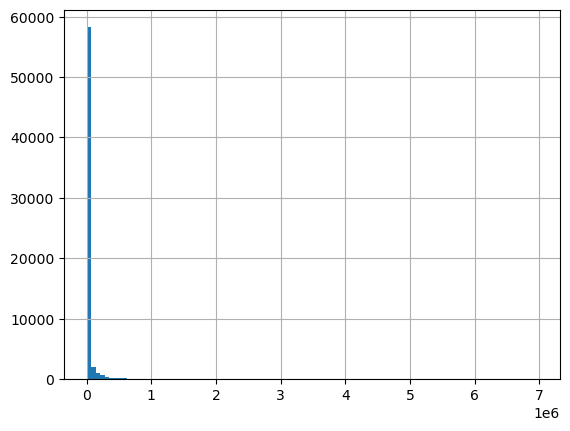

In [38]:
# look at lot-size distribution
df.lotsizesquarefeet.hist(bins = 100)

In [39]:
# what is the median lot size?

df.lotsizesquarefeet.median()

7313.0

In [40]:
# fill missing values with median null sizes

df.lotsizesquarefeet.fillna(7313, inplace = True)

In [41]:
df.shape

(71355, 23)

In [42]:
df.isnull().sum()

Unnamed: 0                         0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
buildingqualitytypeid              0
calculatedfinishedsquarefeet       0
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet                  0
rawcensustractandblock             0
regionidcity                    1322
regionidcounty                     0
regionidzip                       40
roomcnt                            0
yearbuilt                         35
structuretaxvaluedollarcnt        75
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
dtype: int64

In [43]:
# I am going to drop the rest of nulls 

df.dropna(inplace = True)

In [44]:
# How many rows and columns are left?

df.shape

(69919, 23)

In [45]:
df.head()

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,...,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01
1,1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,...,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01
2,2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,...,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01
3,3,12177905,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,...,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01
4,4,10887214,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,...,96451.0,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01


### Check for outliers in select columns

<AxesSubplot:ylabel='taxvaluedollarcnt'>

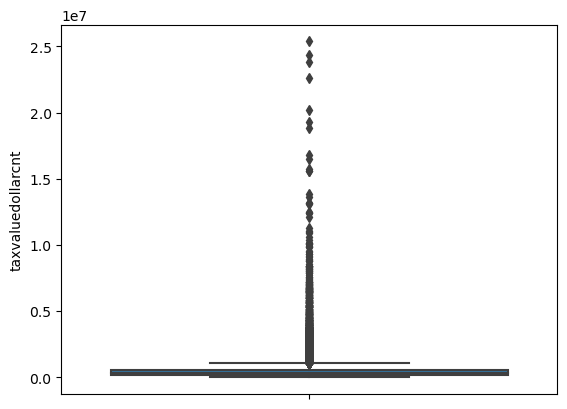

In [46]:
# plt.subplot(221)
sns.boxplot(y = 'taxvaluedollarcnt', data = df)

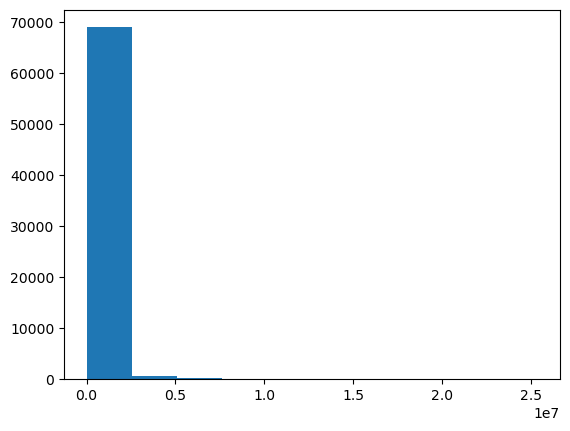

In [47]:
#Histograms for taxvalue of properties

plt.hist(df.taxvaluedollarcnt);

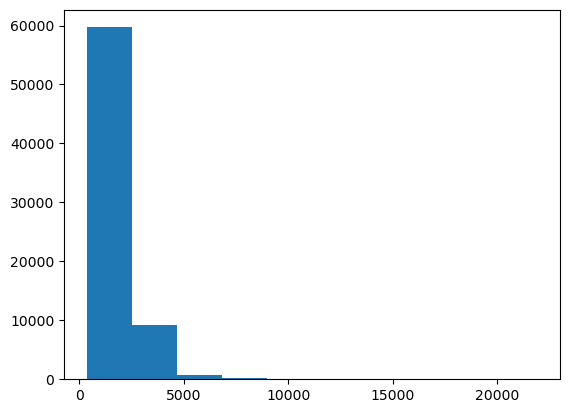

In [48]:
#Histograms for covered sq ft of properties

plt.hist(df.calculatedfinishedsquarefeet);

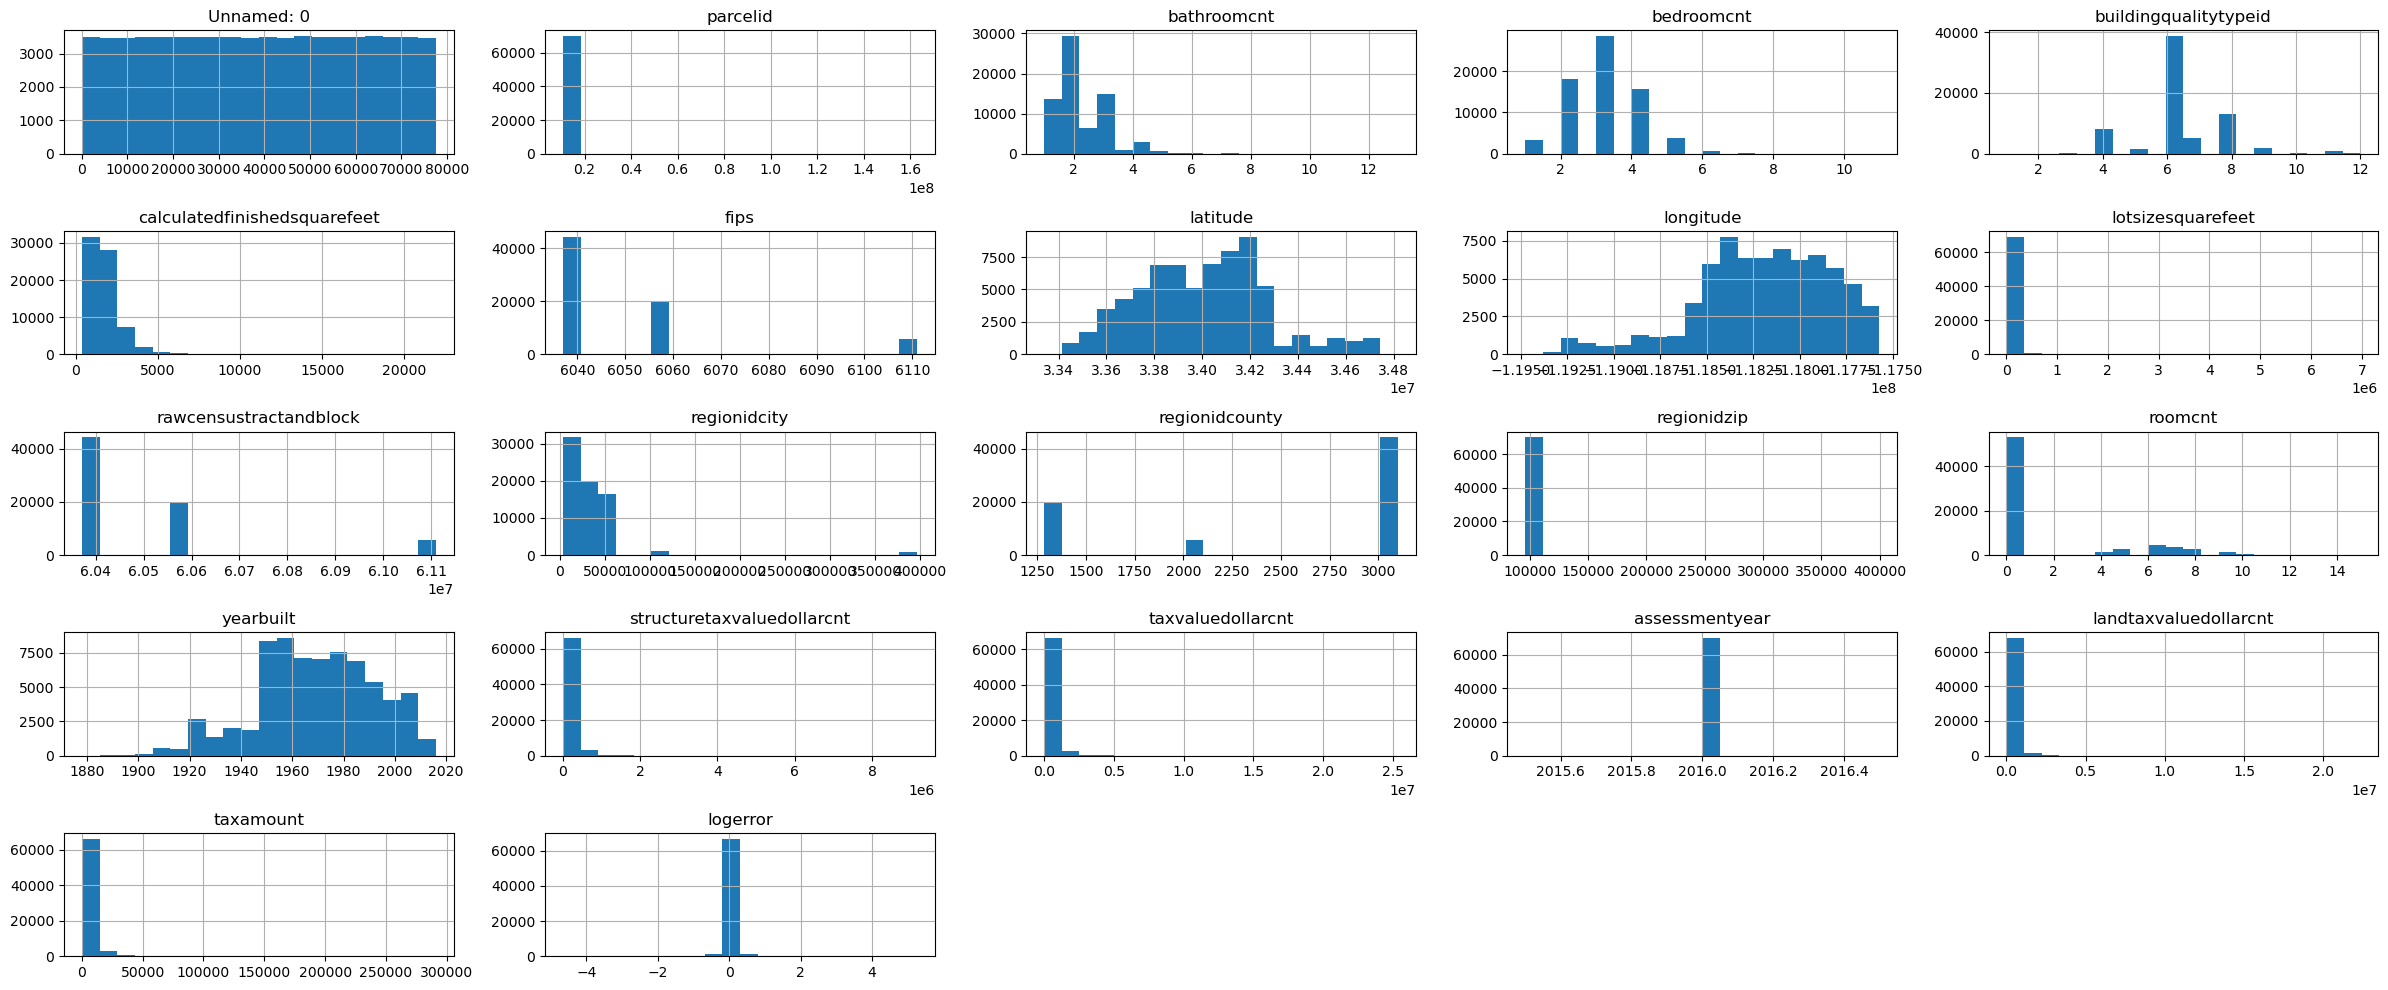

In [49]:
# look at distributions for all columns

df.hist(figsize=(24, 10), bins=20)
plt.tight_layout();

In [50]:
# Remove properties valued more than 5 million dollars

df = df[df.taxvaluedollarcnt < 5_000_000]
df.shape

(69729, 23)

In [51]:
# Remove properties valued more than 8000 square feet

df[df.calculatedfinishedsquarefeet < 8000]
df.shape

(69729, 23)

In [52]:
# Function to read and wrangle data:

def wrangle_zillow():
    df = pd.read_csv('zillow.csv')
    
    # Restrict df to only properties that meet single unit use criteria
    single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
    df = df[df.propertylandusetypeid.isin(single_use)]
    
    # Restrict df to only those properties with at least 1 bath & bed and 350 sqft area
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>350)]

    # Handle missing values i.e. drop columns and rows based on a threshold
    df = handle_missing_values(df)
    
    # Add column for counties
    df['county'] = np.where(df.fips == 6037, 'Los_Angeles',
                           np.where(df.fips == 6059, 'Orange', 
                                   'Ventura'))    
    # drop columns not needed
    df = remove_columns(df, ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc','heatingorsystemdesc','unitcnt'
                            ,'buildingqualitytypeid'])


    # replace nulls in unitcnt with 1
#     df.unitcnt.fillna(1, inplace = True)
    
    # assume that since this is Southern CA, null means 'None' for heating system
#     df.heatingorsystemdesc.fillna('None', inplace = True)
    
    # replace nulls with median values for select columns
    df.lotsizesquarefeet.fillna(7313, inplace = True)
#     df.buildingqualitytypeid.fillna(6.0, inplace = True)

    # Columns to look for outliers
    df = df[df.taxvaluedollarcnt < 5_000_000]
    df[df.calculatedfinishedsquarefeet < 8000]
    
    # Just to be sure we caught all nulls, drop them here
    df = df.dropna()
    
    return df

In [53]:
df2 = wrangle_zillow()
df2.head()

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,...,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,county
0,0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,6.059063e+07,...,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01,Orange
1,1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,6.111001e+07,...,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,Ventura
2,2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,6.059022e+07,...,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,Orange
3,3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,6.037300e+07,...,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Los_Angeles
4,4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,6.037124e+07,...,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01,Los_Angeles


In [54]:
df.head()

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,0,14297519,3.5,4.0,6.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,...,96978.0,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01
1,1,17052889,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,...,97099.0,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01
2,2,14186244,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,...,97078.0,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01
3,3,12177905,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,...,96330.0,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01
4,4,10887214,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,...,96451.0,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,0.006940,2017-01-01


In [55]:
df2.shape

(69729, 23)

In [56]:
df.shape

(69729, 23)

### Mall Customers

In [57]:
sql = 'select * from customers'

In [58]:
# acquire mall customers data using the query:

def get_mall_customers(sql):
    url = get_db_url('mall_customers')
    mall_df = pd.read_sql(sql, url, index_col='customer_id')
    return mall_df

In [59]:
# acquire data

mall_df = get_mall_customers(sql)

In [60]:
mall_df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [61]:
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [62]:
mall_df.shape

(200, 4)

In [63]:
mall_df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [64]:
mall_df.isnull().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [65]:
mall_df.gender.value_counts()

Female    112
Male       88
Name: gender, dtype: int64

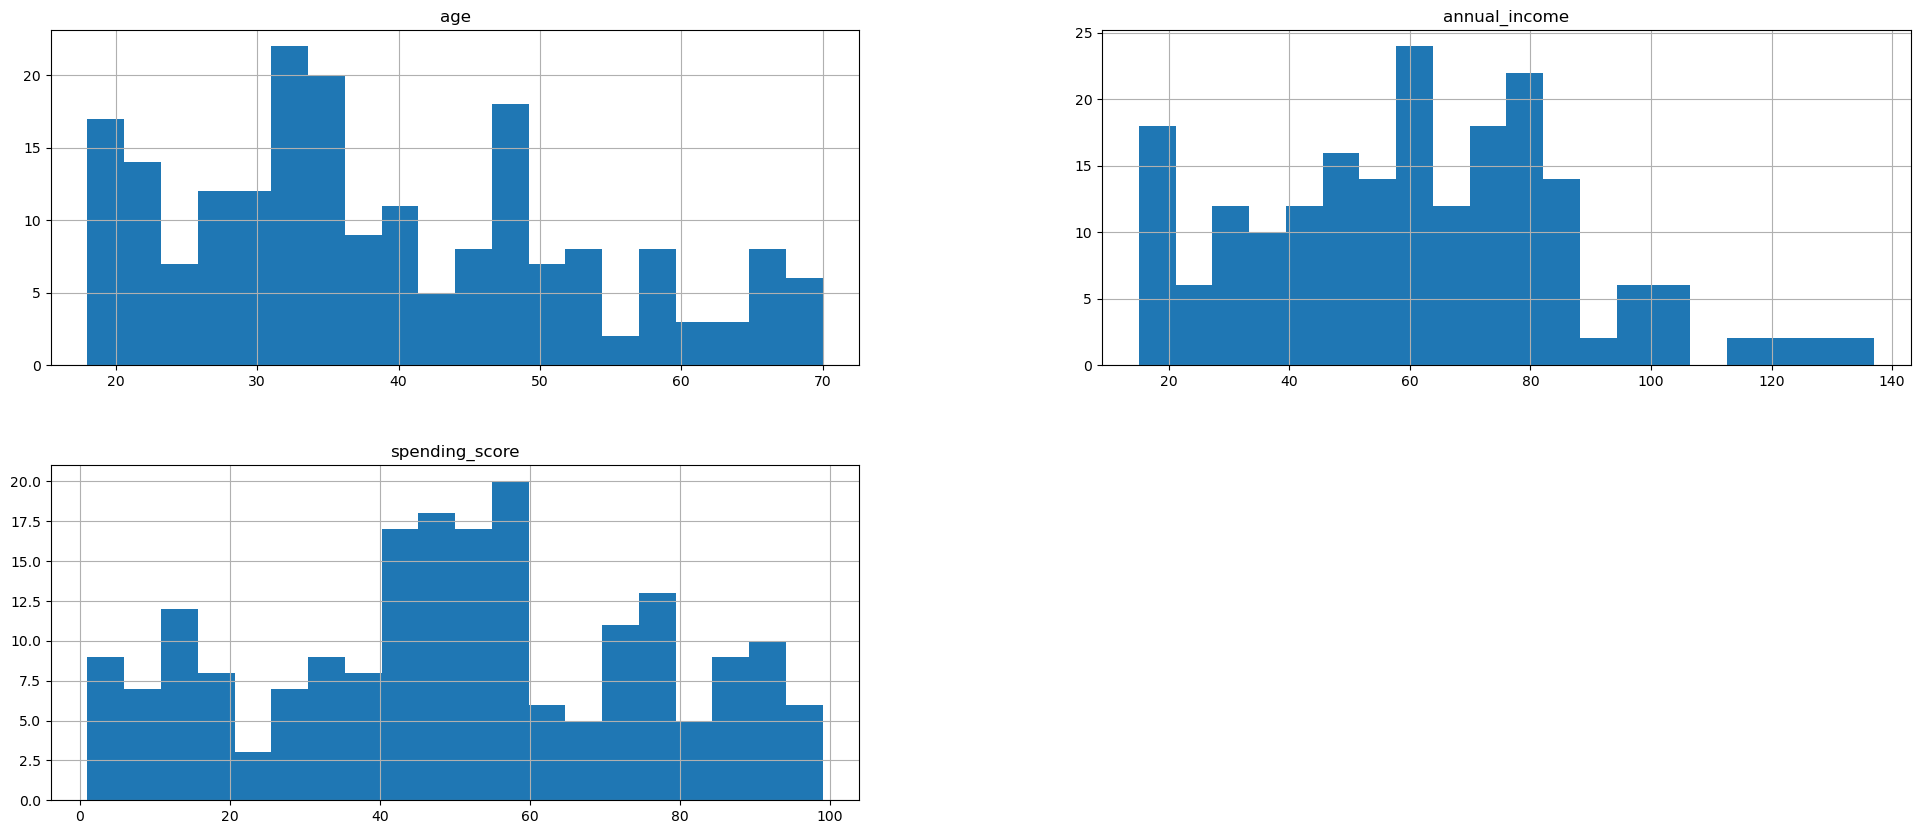

In [66]:
mall_df.hist(figsize=(24, 10), bins=20);

<AxesSubplot:ylabel='spending_score'>

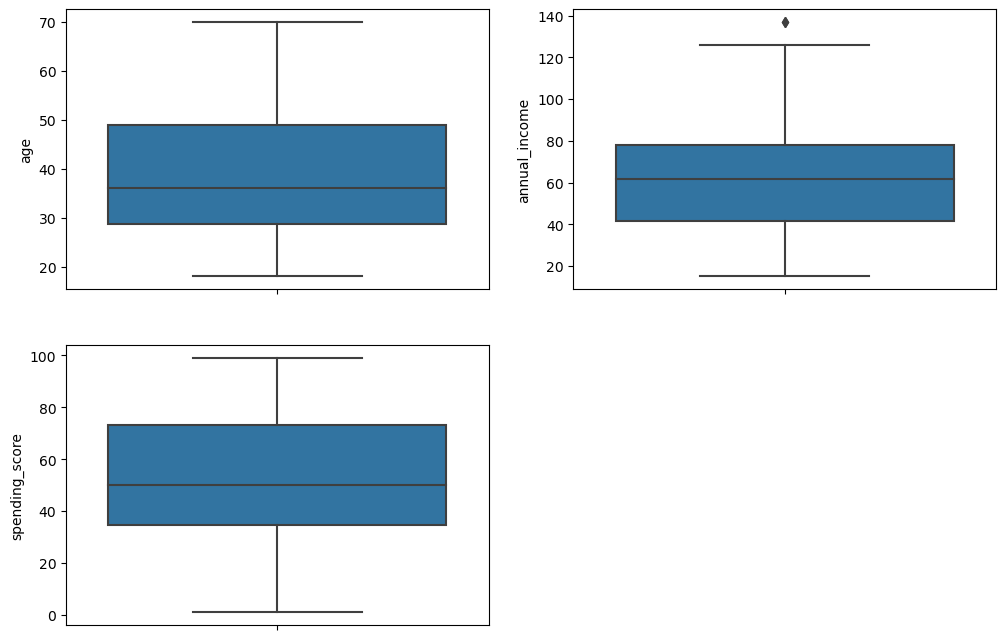

In [67]:
# visualize outliers using boxplots:

plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = mall_df.age)

plt.subplot(222)
sns.boxplot(y = mall_df.annual_income)

plt.subplot(223)
sns.boxplot(y = mall_df.spending_score)

Seems like we have only few outliers based on income column

In [68]:
# Calculate q1, q3 and iqr for income

q1 = mall_df.annual_income.quantile(0.25)
q3 = mall_df.annual_income.quantile(0.75)
iqr = q3 - q1
k = 1.5

# calculate upper and lower ranges
upper_bound_income =  q3 + k * iqr
lower_bound_income =  q1 - k * iqr

lower_bound_income, upper_bound_income

(-13.25, 132.75)

In [69]:
mall_df[mall_df.annual_income > upper_bound_income]

,gender,age,annual_income,spending_score
customer_id,,,,
199,Male,32,137,18
200,Male,30,137,83


In [70]:
# function to detect and eliminate outliers using IQR rule

def outlier_function(df, cols, k):
    for col in df[cols]:
        q1 = mall_df.annual_income.quantile(0.25)
        q3 = mall_df.annual_income.quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr     
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

In [71]:
# use the outlier function defined above to handle outliers in numeric columns. k = 1.5

mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)
mall_df.shape

(198, 4)

In [72]:
mall_df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Encode categorical columns using a one hot encoder (pd.get_dummies).

In [73]:
# encode the gender column

dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
dummy_df.head()

,Male
customer_id,
1,1
2,1
3,0
4,0
5,0


In [74]:
# concat the dummies df with original df. Drop the 'gender' column

mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])
mall_df.head()

,age,annual_income,spending_score,Male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0


#### Split data (train, validate, and test split).


In [75]:
train, test = train_test_split(mall_df, train_size = 0.8, random_state = 123)
train, validate = train_test_split(train, train_size = 0.75, random_state = 123)

In [76]:
# check shape
train.shape, validate.shape, test.shape

((118, 4), (40, 4), (40, 4))

#### Scaling numeric columns

In [77]:
train.head()

,age,annual_income,spending_score,Male
customer_id,,,,
182,32,97,86,0
49,29,40,42,0
35,49,33,14,0
186,30,99,97,1
114,19,64,46,1


In [78]:
def min_max_scaler(train, valid, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    num_vars = list(train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1))
    train[num_vars] = scaler.fit_transform(train[num_vars])
    valid[num_vars] = scaler.transform(valid[num_vars])
    test[num_vars] = scaler.transform(test[num_vars])
    return scaler, train, valid, test

In [79]:
train.select_dtypes('number').columns

Index(['age', 'annual_income', 'spending_score', 'Male'], dtype='object')

In [80]:
# use the scaler
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [81]:
train_scaled.head()

,age,annual_income,spending_score,Male
customer_id,,,,
182,0.269231,0.738739,0.867347,0.0
49,0.211538,0.225225,0.418367,0.0
35,0.596154,0.162162,0.132653,0.0
186,0.230769,0.756757,0.979592,1.0
114,0.019231,0.441441,0.459184,1.0


In [82]:
# Write a master wrangle fuction which acquires and prepares the data

def wrangle_mall_df():
    
    # acquire data
    sql = 'select * from customers'
    mall_df = get_mall_customers(sql)
    
    # handle outliers
    mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)
    
    # get dummy for gender column
    dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
    mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])
    mall_df.rename(columns= {'Male': 'is_male'}, inplace = True)

    # split the data in train, validate and test
    train, test = train_test_split(mall_df, train_size = 0.8, random_state = 123)
    train, validate = train_test_split(train, train_size = 0.75, random_state = 123)
    
    return min_max_scaler, train, validate, test

In [83]:
# use the wrangle function:

scaler, train, validate, test = wrangle_mall_df()

In [84]:
#scaled the values
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [85]:
train_scaled.head(3)

,age,annual_income,spending_score,is_male
customer_id,,,,
182,0.269231,0.738739,0.867347,0.0
49,0.211538,0.225225,0.418367,0.0
35,0.596154,0.162162,0.132653,0.0
